In [3]:
import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [11]:
# ML Algorithms used 
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('../input/zikavirusdataset/classification_dataset.csv')
df.head()

,density_per_km,latitude,longitude,maxtempC,mintempC,totalSnow_cm,sunHour,moon_illumination,DewPointC,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,year,month,Target
0,12625.800781,-34.603684,-58.381559,24,7,0.0,11.6,87,6,16,0,59,0.0,1018,10,189,2016,3,1
1,12625.800781,-34.603684,-58.381559,24,7,0.0,11.6,87,6,16,0,59,0.0,1018,10,189,2016,3,0
2,12625.800781,-34.603684,-58.381559,24,7,0.0,11.6,87,6,16,0,59,0.0,1018,10,189,2016,3,1
3,12625.800781,-34.603684,-58.381559,24,7,0.0,11.6,87,6,16,0,59,0.0,1018,10,189,2016,3,0
4,12625.800781,-34.603684,-58.381559,22,10,0.0,11.5,76,10,27,34,72,0.0,1025,10,99,2016,3,0


In [5]:
df = df.drop_duplicates(keep='first', inplace=False)

In [6]:
df.shape

(75345, 19)

In [12]:
feature_scale = [feature for feature in df.columns if feature not in ['Target']]

scaler=MinMaxScaler()
scaler.fit(df[feature_scale])

# transform the train and test set, and add on the Id and SalePrice variables
data = pd.concat([df[['Target']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)],axis=1)

data.head()

,Target,density_per_km,latitude,longitude,maxtempC,mintempC,totalSnow_cm,sunHour,moon_illumination,DewPointC,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,year,month
0,1,0.505636,0.196981,0.742734,0.641791,0.567164,0.0,0.625806,0.87,0.622642,0.164835,0.00,0.559140,0.000000,0.602941,1.0,0.531429,0.333333,0.181818
1,0,0.505636,0.196981,0.742734,0.641791,0.567164,0.0,0.625806,0.87,0.622642,0.164835,0.00,0.559140,0.000000,0.602941,1.0,0.531429,0.333333,0.181818
2,0,0.505636,0.196981,0.742734,0.611940,0.611940,0.0,0.619355,0.76,0.698113,0.285714,0.34,0.698925,0.000000,0.705882,1.0,0.274286,0.333333,0.181818
3,1,0.505636,0.196981,0.742734,0.611940,0.611940,0.0,0.619355,0.76,0.698113,0.285714,0.34,0.698925,0.000000,0.705882,1.0,0.274286,0.333333,0.181818
4,0,0.505636,0.196981,0.742734,0.611940,0.731343,0.0,0.432258,0.26,0.792453,0.175824,0.61,0.763441,0.097011,0.558824,0.8,0.291429,0.333333,0.272727


In [13]:
X = data.drop('Target',axis=1)
y = data['Target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.50,random_state=10,stratify=y) #train test split in 50:50 ratio

In [14]:
X_train.shape, y_train.shape

((37672, 18), (37672,))

# Ensembling & Stacking models

In [7]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)

In [23]:
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

## 1. CatBoost

In [35]:
cat_params = {
    'depth': 3,
    'learning_rate': 0.02,
    'l2_leaf_reg': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': False
}
cat_model = ClassifierModel(clf=CatBoostClassifier, params=cat_params)
cat_scores, cat_train_pred = trainModel(cat_model,X_train, y_train, X_test, 5, 0) 
cat_scores

array([0.59747843, 0.59628401, 0.61149456, 0.6007433 , 0.59052296])

In [36]:
# Getting features importance 
cat_features = cat_model.feature_importances(X_train,y_train)
cat_features

array([8.34301509e+00, 3.25492939e+01, 3.47574622e+01, 2.00930951e+00,
       2.75741587e+00, 1.70797906e-02, 4.44119495e-01, 4.69182827e-01,
       5.49959302e+00, 7.92637077e-01, 2.13325321e-01, 9.27040511e-01,
       1.88065199e-01, 3.36551959e-01, 2.68927065e-02, 6.76696118e-01,
       6.71638188e+00, 3.27593759e+00])

## 2. AdaBoost

In [27]:
ada_params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores, ada_train_pred = trainModel(ada_model,X_train, y_train, X_test, 5, 0) 
ada_scores

array([0.59601858, 0.59893829, 0.61202548, 0.59755774, 0.5953013 ])

In [28]:
# Getting features importance 
ada_features = ada_model.feature_importances(X_train,y_train)
ada_features

array([0.102, 0.506, 0.172, 0.028, 0.018, 0.   , 0.004, 0.   , 0.032,
       0.008, 0.   , 0.018, 0.   , 0.004, 0.   , 0.006, 0.042, 0.06 ])

## 3. XGBoost

In [65]:
# Gradient Boosting parameters
gb_params = {
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 5,
    'objective':'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method':'gpu_hist'
}
gbc_model = ClassifierModel(clf=XGBClassifier, params=gb_params)
gbc_scores, gbc_train_pred  = trainModel(gbc_model,X_train, y_train, X_test, 5, 0) # Random Forest
gbc_scores

array([0.59761115, 0.59681486, 0.61069817, 0.59370852, 0.58574462])

In [66]:
# Getting features importance 
gbc_features = gbc_model.feature_importances(X_train,y_train)
gbc_features

array([0.05245697, 0.11457556, 0.09949939, 0.06273969, 0.11399798,
       0.00903043, 0.0207065 , 0.02426713, 0.20348077, 0.02499611,
       0.01900807, 0.02477778, 0.01419837, 0.01712074, 0.01155237,
       0.02053501, 0.08678521, 0.08027191], dtype=float32)

## 4. RandomForest

In [67]:
# Random Forest parameters
rf_params = {
    'n_estimators': 500,
    'max_depth': 8,
    'criterion': 'entropy',
    'max_features' : 'sqrt',
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores , rfc_train_pred= trainModel(rfc_model,X_train, y_train, X_test, 5, 0)
rfc_scores

array([0.59575315, 0.58832117, 0.60459251, 0.59662862, 0.58614282])

In [48]:
# Getting features importance 
rfc_features = rfc_model.feature_importances(X_train,y_train)
rfc_features

array([0.0991171 , 0.18212245, 0.20728742, 0.05791408, 0.0798977 ,
       0.00080829, 0.0221582 , 0.01213565, 0.09096311, 0.02661363,
       0.02104943, 0.02792995, 0.01710457, 0.01666045, 0.00669135,
       0.0299898 , 0.0545579 , 0.04699893])

## 5. Decision Tree

In [68]:
# Random Forest parameters
dt_params = {
    'max_depth': 5,
    'criterion': 'gini',
    'min_samples_leaf': 10,
    'min_samples_split': 5,
    'splitter': 'best',
}
dtc_model = ClassifierModel(clf=DecisionTreeClassifier, params=dt_params)
dtc_scores, dtc_train_pred = trainModel(dtc_model,X_train, y_train, X_test, 5, 0)
dtc_scores

array([0.58845388, 0.58566689, 0.59968144, 0.58999204, 0.59198301])

In [69]:
# Getting features importance 
dtc_features = dtc_model.feature_importances(X_train,y_train)
dtc_features

array([0.0426071 , 0.42174615, 0.23623582, 0.00142914, 0.        ,
       0.        , 0.        , 0.        , 0.20796164, 0.        ,
       0.        , 0.01334769, 0.00159791, 0.        , 0.        ,
       0.        , 0.05457612, 0.02049841])

## Features Importance

In [53]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': X.columns.values,
    'CatBoost featureImp': cat_features,
    'AdaBoost featureImp': ada_features,
    'XGBoost featureImp': gbc_features,
    'Random Forest featureImp': rfc_features,
    'Decision Trees featureImp': dtc_features,
    })

In [60]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe = feature_dataframe.sort_values(by='mean',ascending=False)
feature_dataframe

,features,CatBoost featureImp,AdaBoost featureImp,XGBoost featureImp,Random Forest featureImp,Decision Trees featureImp,mean
2,longitude,34.757462,0.172,0.099499,0.207287,0.243210,7.095892
1,latitude,32.549294,0.506,0.114576,0.182122,0.414772,6.753353
0,density_per_km,8.343015,0.102,0.052457,0.099117,0.042607,1.727839
16,year,6.716382,0.042,0.086785,0.054558,0.054576,1.390860
8,DewPointC,5.499593,0.032,0.203481,0.090963,0.207962,1.206800
17,month,3.275938,0.060,0.080272,0.046999,0.020498,0.696741
4,mintempC,2.757416,0.018,0.113998,0.079898,0.000000,0.593862
3,maxtempC,2.009310,0.028,0.062740,0.057914,0.001429,0.431878
11,humidity,0.927041,0.018,0.024778,0.027930,0.013348,0.202219
9,WindGustKmph,0.792637,0.008,0.024996,0.026614,0.000000,0.170449


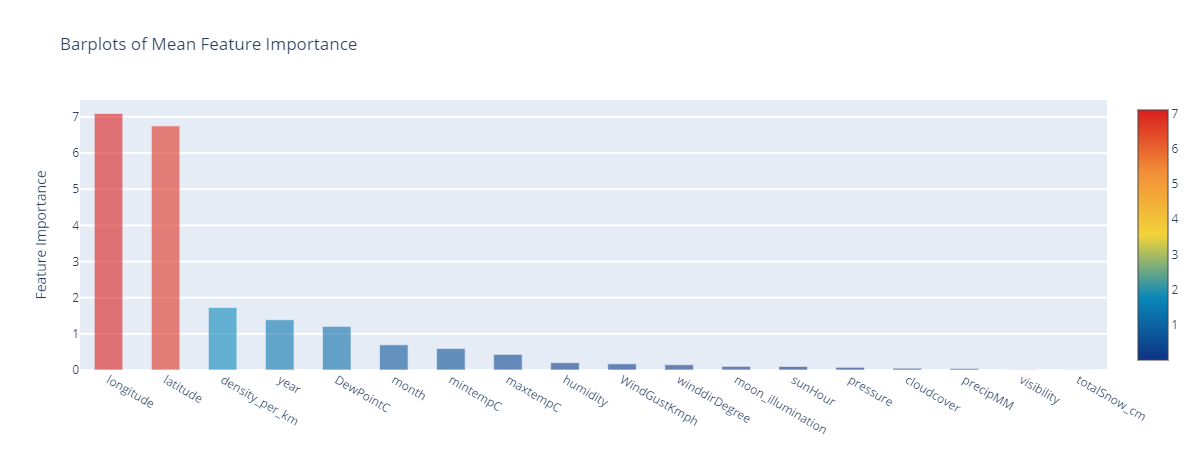

In [61]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [71]:
acc_pred_train = pd.DataFrame ({
    'CatBoost': cat_scores.ravel(),
    'AdaBoost': ada_scores.ravel(),
    'XGBoost': gbc_scores.ravel(),
    'DesicionTree': dtc_scores.ravel(),
    'RandomForest': rfc_scores.ravel(),
    })
acc_pred_train.head()

,CatBoost,AdaBoost,XGBoost,DesicionTree,RandomForest
0,0.597478,0.596019,0.597611,0.588454,0.595753
1,0.596284,0.598938,0.596815,0.585667,0.588321
2,0.611495,0.612025,0.610698,0.599681,0.604593
3,0.600743,0.597558,0.593709,0.589992,0.596629
4,0.590523,0.595301,0.585745,0.591983,0.586143


<AxesSubplot:title={'center':'Pearson correlation of features'}>

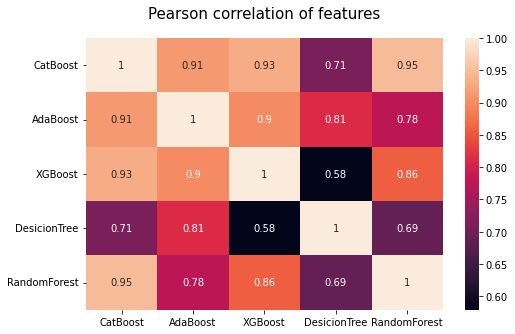

In [78]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8,5))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)

In [73]:
x_train = np.column_stack(( cat_train_pred, ada_train_pred, gbc_train_pred, dtc_train_pred, rfc_train_pred))
x_train

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

In [76]:
x_train.shape

(37672, 5)

In [75]:
acc_pred_train

,CatBoost,AdaBoost,XGBoost,DesicionTree,RandomForest
0,0.597478,0.596019,0.597611,0.588454,0.595753
1,0.596284,0.598938,0.596815,0.585667,0.588321
2,0.611495,0.612025,0.610698,0.599681,0.604593
3,0.600743,0.597558,0.593709,0.589992,0.596629
4,0.590523,0.595301,0.585745,0.591983,0.586143


In [80]:
def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    gbm = CatBoostClassifier(
        depth=3,learning_rate=0.02,
        l2_leaf_reg=10,
        loss_function='Logloss', 
        eval_metric='Accuracy',
        verbose=False).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [82]:
stackModel_scores = trainStackModel(x_train, y_train, X_test, 5, 0)

In [83]:
acc_pred_train['stackingModel'] = stackModel_scores
acc_pred_train

,CatBoost,AdaBoost,XGBoost,DesicionTree,RandomForest,stackingModel
0,0.597478,0.596019,0.597611,0.588454,0.595753,0.598673
1,0.596284,0.598938,0.596815,0.585667,0.588321,0.598275
2,0.611495,0.612025,0.610698,0.599681,0.604593,0.615477
3,0.600743,0.597558,0.593709,0.589992,0.596629,0.601274
4,0.590523,0.595301,0.585745,0.591983,0.586143,0.590788
